# Détectez les Bad Buzz grâce au Deep Learning

## Objectif du projet

Développer le prototype d’un produit IA permettant de prédire le sentiment associé à un tweet

## Les approches

- Approche “Modèle sur mesure simple”, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.

- Approche “Modèle sur mesure avancé” pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet. => C’est ce modèle que tu devras déployer et montrer à Air Paradis.

- L’apport en performance d’un modèle BERT ? Cela nous permettra de voir si nous devons investir dans ce type de modèle.


In [2]:
!python -V

Python 3.9.12


## Import modules

In [2]:
# utilities
import re
import pandas as pd
import numpy as np
import tensorflow as tf

# plotting
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# sklearn
from numpy import mean
from numpy import std

# Scikit-learn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



# nltk
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

# Keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Input,SpatialDropout1D,Conv1D
from keras.models import Sequential
from keras.layers import  Dropout , LSTM , Dense
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
#gensim
import spacy

# Word2vec
import gensim
from gensim.models import Word2Vec

import time
import itertools

## Settings

In [2]:
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

## Load datas

In [3]:
data = pd.read_csv('C:/Users/CE PC/Documents/IA_P7/datas/training.1600000.processed.noemoticon.csv'  , encoding = "ISO-8859-1"
                    ,header=None
                  
                  )

In [4]:
data = pd.read_csv('C:/Users/CE PC/Documents/IA_P7/datas/training.1600000.processed.noemoticon.csv' ,encoding_errors="ignore" , header=None ,names= ["target","id","date","tag","user","tweet"])

In [5]:
data

,target,id,date,tag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
data.shape

(1600000, 6)

## Preprocessing dataset

In [7]:
## Saving the necessary columns.

df_tweet = data[["target", "tweet"]]
df_tweet

,target,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
df_tweet=df_tweet.replace(4,1)
df_tweet

,target,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [9]:
df_tweet['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

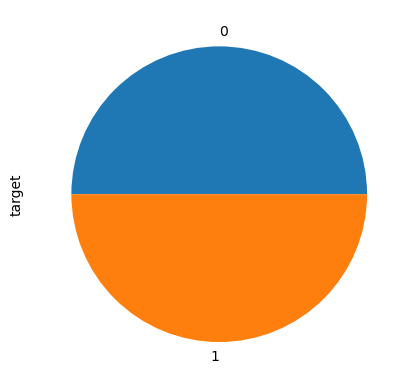

In [10]:
df_tweet.target.value_counts().plot(kind='pie')

C:\Users\CE PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'tweets')

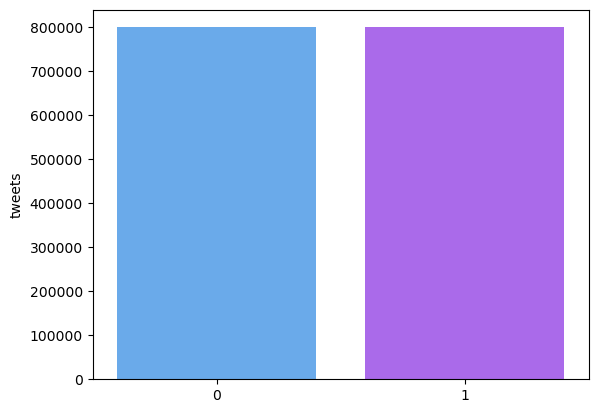

In [11]:
#Checking the class distribution
x = df_tweet.target.value_counts()
sns.barplot(x.index, x, palette='cool')
plt.gca().set_ylabel('tweets')

Text(0.5, 0.98, 'Characters in tweets')

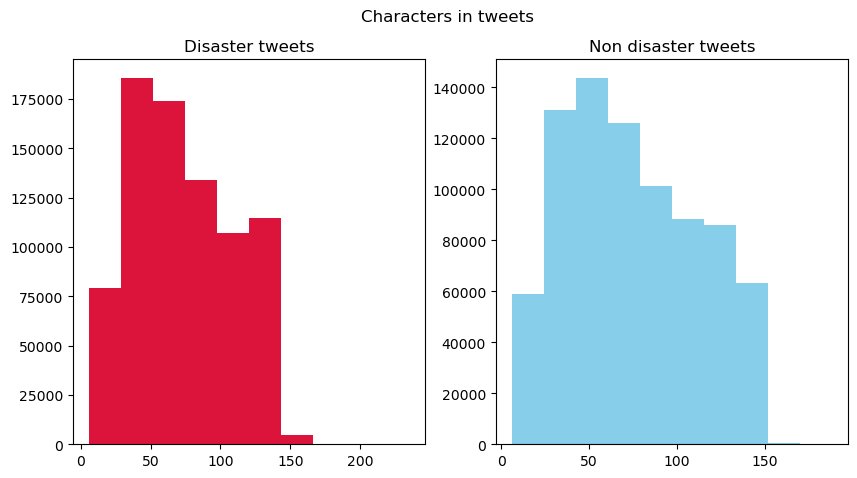

In [12]:
#Number of characters in tweets
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = df_tweet[df_tweet['target']==1]['tweet'].str.len()
ax1.hist(tweet_len,color='crimson')
ax1.set_title('Disaster tweets')
tweet_len = df_tweet[df_tweet['target']==0]['tweet'].str.len()
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Non disaster tweets')
fig.suptitle('Characters in tweets')

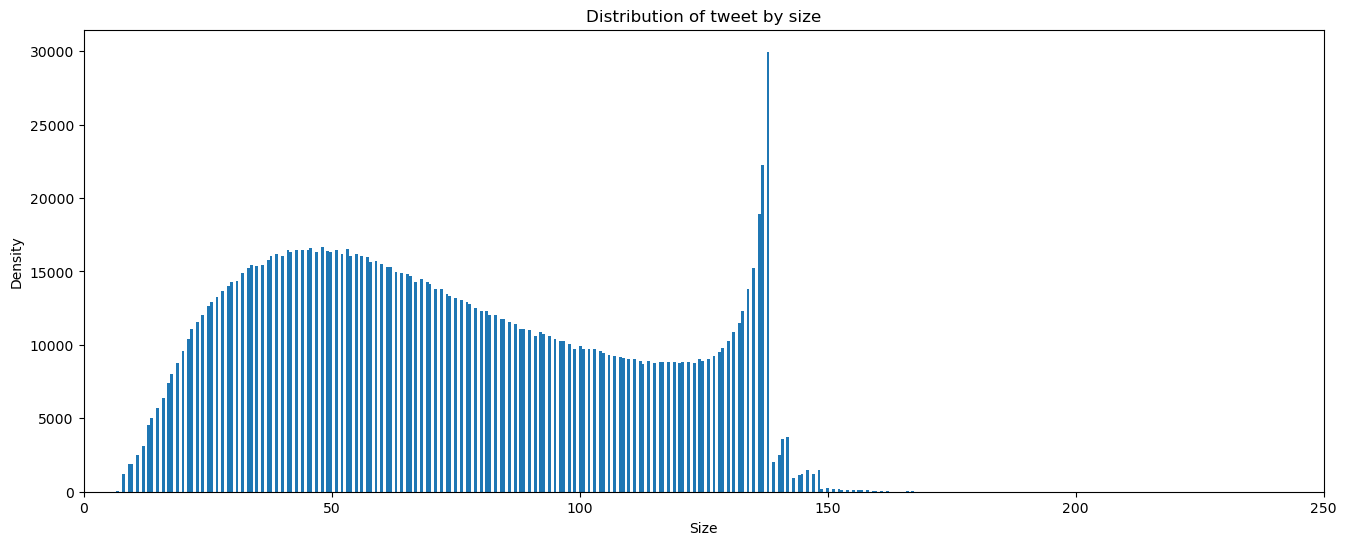

In [13]:
sizes=[len(i) for i in df_tweet['tweet']]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of tweet by size',
              #- [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,250])
plt.show()

In [14]:

sizes=[len(i) for i in df_tweet['tweet']]
max(sizes)

235

In [15]:
from collections import Counter
sizes=[len(i) for i in df_tweet['tweet']]
sorted_list = sorted(sizes, reverse=True)
sorted_counted = Counter(sorted_list)

<AxesSubplot:>

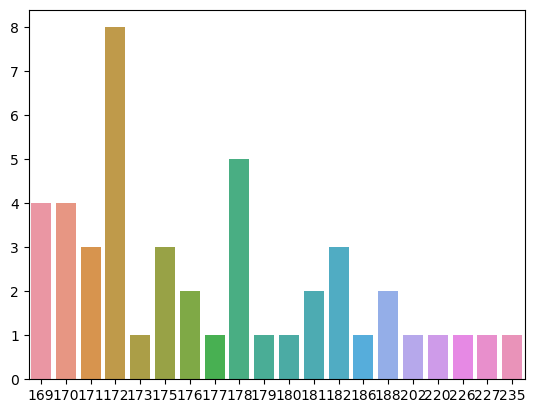

In [16]:
from collections import Counter
import numpy as np
import pandas as pd

keys = list(sorted_counted.keys())
# get values in the same order as keys, and parse percentage values
vals = [float(sorted_counted[k]) for k in keys]
sns.barplot(x=keys[:20], y=vals[:20])

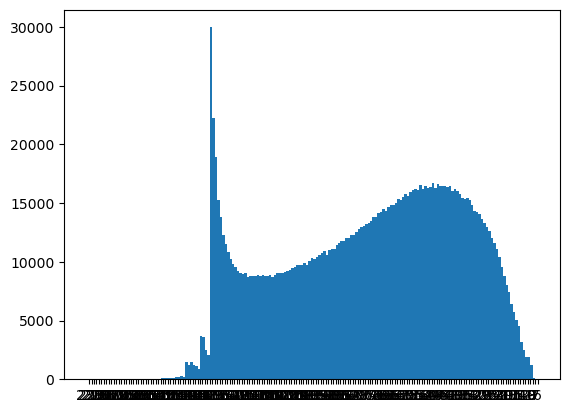

In [17]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


labels, values = zip(*Counter(sorted_list).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

# I. Modèle sur mesure simple


**Modélisation**

**La régression logistique**
La régression logistique est un algorithme de classification d'apprentissage supervisé utilisé pour prédire la probabilité d'une variable cible.
Mathématiquement, un modèle de régression logistique prédit P (Y = 1) en fonction de X. C'est l'un des algorithmes ML les plus simples qui peut être utilisé pour divers problèmes de classification tels que la détection de spam, la prédiction du diabète, la détection du cancer, etc.


## Split dataset

Nous allons diviser un jeu de données en deux parties :

- Training data : utilisé pour le modèle de formation.
- Test :utilisée pour vérifier la précision du modèle entraîné

In [18]:
#sample 16000 tweets
df_sample=df_tweet.sample(frac=0.01,random_state=60) 
df_sample

,target,tweet
425383,0,says I really love my phone!! But i need a ne...
227432,0,"Ohhh I love you and i miss you @heeymary , i ..."
1073041,1,@williepryorjr Hahaha.
872313,1,@jasongroupp 0% here in Oregon.
337030,0,i'm going to kill my dog she just ate my flip ...
...,...,...
1031294,1,Statut twitter de leane = so boutch. Jvs aime....
1422689,1,@orangepiper88 Looks like I need to add you fo...
841738,1,Flight landed within 20 minutes of ea other ra...
337561,0,argh...sinusitis!


In [19]:
# Storing data in lists.
tweet, target = (df_sample['tweet']), (df_sample['target'])
# Let's split the whole dataset into a training set (70% of data) and a test set (30% of data)
# The dataset will be split in a stratified way, in order to have a good distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(tweet, target, test_size=0.3, random_state=1)


In [20]:
X_train.shape,X_test.shape


((11200,), (4800,))

## Vectorization TF-IDF

On compte le nombre d'apparitions du mot dans le document (TF : Term Frequency)
On pondére par l'inverse du nombre d'apparitions du mot dans l'ensemble des documents (IDF : Inverse Term Frequency)
Par rapport à une représentation Bag-Of-Words, cela permet de donner plus d'importance aux mots qui apparaissent fréquemment dans un document mais peu fréquemment dans les autres documents, ce qui signifie que le mot a de l'importance dans ce document en particulier.

Le centrage et la réduction=standarisation
centrage centrage par la moyenne des variables
reduction=use ecart type

Nous allons maintenant centrer et réduire nos variables prédictives, c'est la [standardisation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Attention à la fuite de données, la base de test doit être normalisée avec les paramètres appris sur la base d'apprentissage. 

<img src='./images/logo_oc.png' width=15px /> Effectuez la standardisation des variables `X_train` et `X_test`.

In [21]:
vectoriser = TfidfVectorizer()
vectoriser = vectoriser.fit(X_train)
print('Number of feature_words: ', len(vectoriser.get_feature_names()))

Number of feature_words:  19905


C:\Users\CE PC\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
#vectoriser.vocabulary

In [23]:
len(vectoriser.vocabulary_)

19905

In [24]:
import gensim
from gensim import corpora
from pprint import pprint
from gensim.utils import simple_preprocess

# Create the Dictionary and Corpus

mydict = corpora.Dictionary([simple_preprocess(line) for line in tweet])
corpus = [mydict.doc2bow(simple_preprocess(line)) for line in tweet]

# Show the Word Weights in Corpus
#for doc in corpus:
#    print([[mydict[id], freq] for id, freq in doc])

In [25]:
from gensim import models
# Create the TF-IDF model
tfidf = models.TfidfModel(corpus, smartirs='ntc')


In [26]:
# Show the TF-IDF weights
#for doc in tfidf[corpus]:
#    print([[mydict[id], np.around(freq, decimals=2)] for id, freq in doc])


In [27]:
#Transforming the data

X_train= vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

## Train model and evaluate

Pour modéliser la relation qu'il existe entre les variables prédictives `X_train` et la cible `y_train`, nous allons utiliser la regression logestique

**Regression logistique:**


- On peut évaluer un modèle sur cet ensemble de données en utilisant la validation croisée k-fold.

- Nous évaluerons un modèle LogisticRegression et utiliserons la classe KFold pour effectuer la validation croisée, configurée pour mélanger l'ensemble de données et définir k = 10, une valeur par défaut populaire.

- La fonction cross_val_score() sera utilisée pour effectuer l'évaluation, en prenant l'ensemble de données et la configuration de la validation croisée et en renvoyant une liste des scores calculés pour chaque pli.

**La validation croisée(k-fold):**

- La méthode consiste à découper le data set en k échantillons.

- On sélectionne x échantillons pour constituer l’échantillon d’apprentissage.

- Les k-x échantillons restants permettront d’évaluer la performance du modèle.

- Pour construire le modèle suivant on sélectionne les échantillons différemment de manière à ne jamais avoir les mêmes échantillons d’apprentissage et de validation.

- Une fois que chaque modèle a pu être entrainé et évalué, il ne reste plus qu’à comparer la performance pour choisir le meilleur modèle.



In [28]:
model=LogisticRegression()
params={"C":np.logspace(-5,3,10), "penalty":["l1","l2"]}# l1 lasso l2 ridge
gsc=GridSearchCV(model,params,cv=5,scoring='accuracy')
logreg_cv=gsc.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

C:\Users\CE PC\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\CE PC\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

tuned hpyerparameters :(best parameters)  {'C': 2.154434690031882, 'penalty': 'l2'}


In [29]:
def perf_model(model_name,clf):
    model= model_name
    y_pred=clf.best_estimator_.predict(X_test)
    y_proba=clf.best_estimator_.predict_proba(X_test)
    
    #calculate performances parameters
    tn, fp, fn, tp=sklearn.metrics.confusion_matrix(y_test,y_pred).ravel()#tn, fp, fn, tp
    cm = confusion_matrix(y_test,y_pred)
    print(classification_report(y_test, y_pred))
    matrix=sns.heatmap(cm,annot=True,cmap='viridis')
    sklearn.metrics.confusion_matrix(y_test,y_pred).ravel(),
     


              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2437
           1       0.75      0.76      0.76      2363

    accuracy                           0.76      4800
   macro avg       0.76      0.76      0.76      4800
weighted avg       0.76      0.76      0.76      4800



None

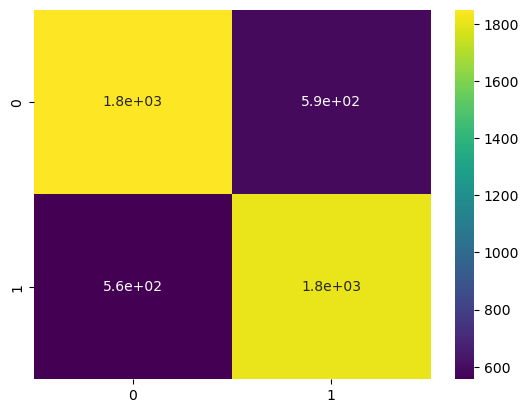

In [30]:
logreg_cv_params=perf_model('Regression Logistique',logreg_cv)
display(logreg_cv_params)

In [31]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.76 (+/- 0.01)


              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2437
           1       0.76      0.76      0.76      2363

    accuracy                           0.76      4800
   macro avg       0.76      0.76      0.76      4800
weighted avg       0.76      0.76      0.76      4800



Text(0.5, 1.0, 'Confusion Matrix')

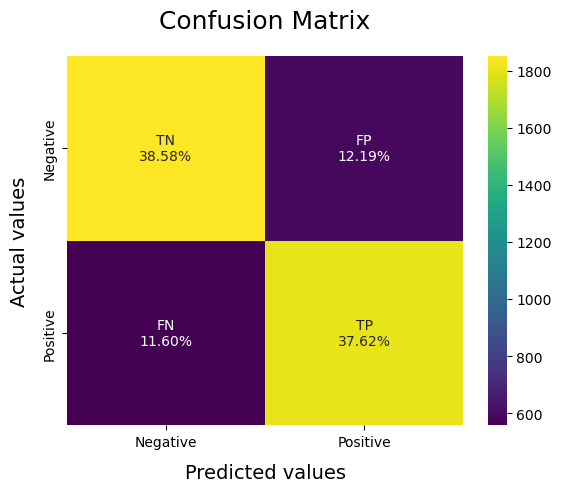

In [32]:
model.fit(X_train, y_train)

# Predict values for Test dataset
y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
#cf_matrix


categories  = ['Negative','Positive']
group_names = ['TN','FP', 'FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'viridis',fmt = '', xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Conclusio

**Nous pouvons clairement voir que notre modèle atteint une précision de 80 % ainsi que le classant le sentiment d'un tweet.**

Conclusion :
La lemmatisation n'améliore pas les résultats : l'accuracy avec les Tweets lemmatises (0.772) est légèrement inférieure à l'accuracy avec les Tweets non lemmatises (0.776)
Cette approche nous a permis de mettre en place un modèle basique de référence va nous servira de comparaison pour évaluer la performance des modèles plus complexes basés sur l'approche Deep Learning (Réseaux de neurones)
L'accuracy du modèle de référence est de 0.776

# II. Modèle avancé

## Preprocessing tweets

In [33]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwords_error = {'a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves'}

### use stopword nltk+spacy+list
#use 16000 tweet

In [34]:
import spacy
#loading the english language small model of spacy
sw = spacy.load('en_core_web_sm')
stopwords = sw.Defaults.stop_words

print(len(stopwords))
#print(stopwords)

C:\Users\CE PC\anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.4.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


326


In [35]:
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= stopwords_error

In [36]:
print(len(nlp.Defaults.stop_words))
print(nlp.Defaults.stop_words)


346
{'per', 'nine', 'various', 'very', 'around', 'regarding', 'last', 'my', 'indeed', 'hers', 'why', 'say', 'among', 'he', 'won', 'nothing', '‘ve', 'up', 'move', 'out', 'whole', 'n‘t', 'few', 'so', 'something', 'whence', 'above', 'that', 's', '‘ll', 'give', 'front', 'whereupon', 'some', 'anyone', 'may', 'whatever', 'being', 'not', 'anyhow', 'has', 'themselves', 'ca', 'even', 'eight', 'below', 'everything', 'put', 'any', 'shes', 'became', 'yourself', 'latter', 'someone', 'itself', 'fifteen', 'wherein', 'her', 't', 'already', 'yours', 'into', 'ten', "'ll", 'then', 'used', 'toward', 'meanwhile', 'therein', 'for', 'youre', 'top', 'us', 'using', 'which', '’m', 'from', 'would', 'be', 'moreover', 'otherwise', 'had', 'they', 'sometimes', 'off', 'what', 'behind', 'who', 'were', 'too', 'thereupon', 'see', 'either', 'between', 'nobody', 'their', 'make', 'via', 'myself', 'becoming', 'shouldve', 'along', 'afterwards', 'however', 'll', 'with', 'over', 'o', 'are', 'please', 'also', 'just', 'y', 'beco

In [37]:
sw =['‘d', 'wherever', '’re', 'hers', "'ll", 'since', 'here', 'two', 'cannot', 'its', 'mine', 'off', 'onto', 'thence', 'ma', 'alone', 'each', 'did', 'what', 'whatever', "'re", 'per', 'or', 'they', 'thatll', 'some', 'do', 'over', 'moreover', 'might', '‘m', 'neither', 'yet', 'less', 'former', 'because', 'various', 'beside', 'toward', 'noone', 'itself', 'as', '‘ll', 'six', 'would', 'myself', 'name', 'therein', 'us', 'those', 'namely', 'used', '’d', 'being', 'several', 'whence', 'bottom', 'whole', 'whether', 'more', 'during', 'anything', 'herein', 'together', 'between', 'forty', 'she', 'please', 'somewhere', 'whereas', 'the', 'take', 'youve', 'whenever', 'very', 'how', 'becomes', 'but', 'own', 'side', 'whom', 'due', 'yourselves', 've', 'eleven', 'which', 'everything', 'three', "'m", 'indeed', 'anywhere', 'with', 'fifteen', 'besides', 'it', 'nobody', 'meanwhile', 'from', 'quite', 'whoever', 'whose', 'really', 'every', 'make', 'no', 'just', 'yourself', 'top', 'made', 'full', 'although', 'any', 'never', 'until', 'we', 'may', 'had', 'further', 'and', "'d", 'elsewhere', 'doing', 'most', 'an', 'others', 'themselves', 'd', 'hereafter', 'is', 'around', 'thereupon', 'anyway', 'put', 'who', 'a', 'too', 'ourselves', 'well', 'them', 're', 'won', 'shouldve', 'still', 'formerly', 'once', 'herself', 'throughout', 'nevertheless', 'ain', 'otherwise', 'except', 'regarding', 'same', 'there', 'why', '‘re', 'n‘t', 'whereupon', 'however', 'for', 'when', 'therefore', 'below', 'thereafter', 'have', 'm', 'after', 'unless', 'hereby', 'about', 'seem', '’s', 'of', 'were', 'yours', 'beforehand', 'thus', 'will', 'few', 'ca', '’ll', 'their', 'five', 'thru', 'often', 'using', 'latter', 'me', 'many', 'again', 'via', 'whither', 'up', 'call', 'thereby', 'amount', 'see', 'even', 'across', 'i', "n't", 'am', 'sixty', 'everyone', 'only', 'though', 'among', 'amongst', 'your', 'if', 'anyone', 'none', 'whereby', 'either', 'upon', 'all', 'at', 'third', "'ve", 'another', 'next', 'least', 'youll', 'sometime', 'such', 't', 'anyhow', 'move', 'this', 'hereupon', 'part', 'already', 'are', 'before', 'ever', 'our', 'into', 'youre', 'nothing', 'been', 'always', '’m', 'must', 'wherein', 'somehow', 'say', 'without', 'whereafter', 'beyond', 'behind', 'out', 'nowhere', 'under', 'll', 'everywhere', 'else', 'that', 'was', 'then', 'youd', 'along', 'while', 'front', 'last', 'rather', '‘s', 'became', 'almost', 'not', '‘ve', 'fifty', 'seemed', 'her', 'shes', 'get', 'also', 'one', 'on', 'o', 'give', 'done', 'y', 'first', 'through', 'seeming', 'much', 'serious', 'become', 'perhaps', 'theirs', 'becoming', 'back', 'nor', "'s", 'latterly', 'should', 'seems', 'has', 'enough', 'where', 'does', 'empty', 'hundred', 'afterwards', 'keep', 'against', 'show', 'ours', 'be', 'down', 'twenty', 'you', 'to', 'ten', 'twelve', 'so', 'by', 'in', 'above', 'having', 'himself', 'someone', 'his', 'towards', 'my', '’ve', 'sometimes', 'hence', 'can', 'nine', 'four', 'him', 'these', 'eight', 'other', 'go', 's', 'mostly', 'now', 'he', 'n’t', 'could', 'within', 'both', 'than', 'something']

In [38]:
from nltk.corpus import stopwords
stopwords_nltk  = stopwords.words('english')


In [39]:
print(len(stopwords_nltk))
print(stopwords_nltk)

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [40]:
stopwords_nltk.extend(sw)

In [41]:
print(len(stopwords_nltk))
print(stopwords_nltk)

525
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [42]:
stopwords_all=stopwords_nltk
len(stopwords_all)

525

In [43]:
def preprocess(textdata):
    processedText = []
    
        
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stopwords_all :
                if len(word)>1:
                    tweetwords += (word+' ')
                
            
        processedText.append(tweetwords)
        
    return processedText

In [44]:
import time
t = time.time()
df_sample['tweet_preprocessed'] = preprocess(tweet)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')
df_sample.head()

Text Preprocessing complete.
Time Taken: 2 seconds


,target,tweet,tweet_preprocessed
425383,0,says I really love my phone!! But i need a ne...,says love phone need new URL
227432,0,"Ohhh I love you and i miss you @heeymary , i ...",ohh love miss USER want x3
1073041,1,@williepryorjr Hahaha.,USER hahaha
872313,1,@jasongroupp 0% here in Oregon.,USER oregon
337030,0,i'm going to kill my dog she just ate my flip ...,going kill dog ate flip flops buy new pair


In [45]:
processedText =preprocess(df_sample['tweet'])

In [46]:
processedText

['says love phone need new URL ',
 'ohh love miss USER want x3 ',
 'USER hahaha ',
 'USER oregon ',
 'going kill dog ate flip flops buy new pair ',
 'find magnum double caramel almond classic white magnums shops d4 ',
 'hammock lounging pool swimming xbox playing busy day ',
 'ignorance twitter people hate use brain ',
 'USER oh man took hrs home dr apt traffic blows ',
 'USER good thing friday sorry rough day ',
 'USER need translator speak bit italian ',
 'USER time big slice small pizza instead great pizza ',
 'USER crapola more4 room look youtube series showing ',
 'USER cracked kohls twitter got summer clothes coupon love big ones ',
 'USER rent going reply tweets ',
 'USER rub day baby ask ',
 'missninab night later ',
 'USER better mind im avoid chem revision ',
 'wants beyonce concert ',
 'USER sry anne net isnt installed furnishing wrk house going hope understand ',
 'whohoo life easier smile EMOJIwink love x3 ',
 'USER lol thanks ',
 'car time stephen ',
 'yep upload images w

In [47]:
print('------Tweet before cleaning :-----')
print('\n')
print(df_sample['tweet'].iloc[12])
print('\n')
print("="*100)
print('\n')
print('------Tweet after cleaning :-----')
print('\n')
print(df_sample['tweet_preprocessed'].iloc[12])

------Tweet before cleaning :-----


@karlphotoboy crapola no more4 in room  must have a look on YouTube - what series is showing?




------Tweet after cleaning :-----


USER crapola more4 room look youtube series showing 


## Visualization datas

In [48]:
processedtweet = df_sample['tweet_preprocessed']

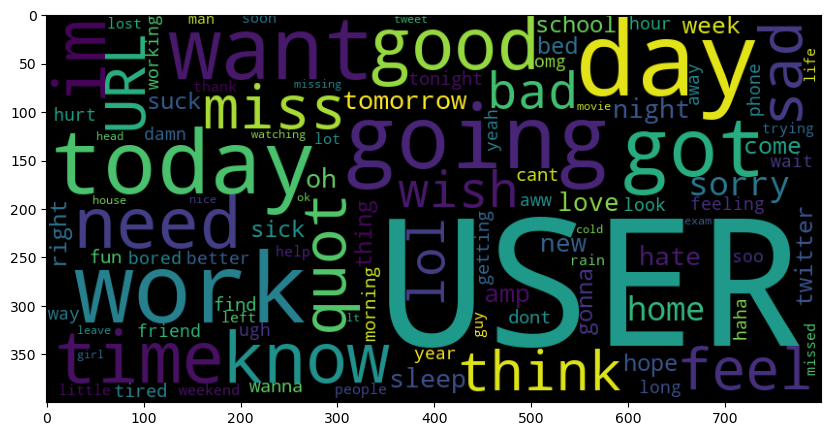

In [49]:
#Word-Cloud for Negative tweets.
neg_tweets = df_sample[df_sample['target'] == 0].tweet_preprocessed
#processedtweet[:8000]
plt.figure(figsize = (10,8))
wc = WordCloud(max_words = 100 , width = 800 , height = 400,
               collocations=False).generate(" ".join(neg_tweets))
plt.imshow(wc)

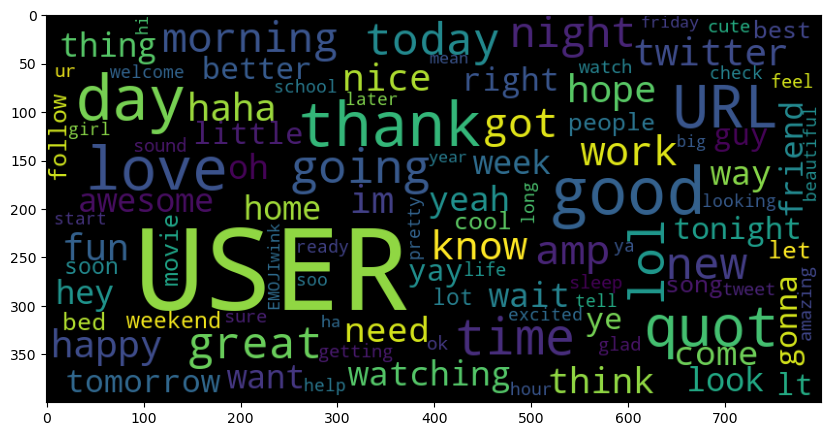

In [50]:
#Word-Cloud for Positive tweets.
pos_tweets = df_sample[df_sample['target'] == 1].tweet_preprocessed

#processedtweet[8000:]
wc = WordCloud(max_words = 100 , width = 800 , height = 400,
              collocations=False).generate(" ".join(pos_tweets))
plt.figure(figsize = (10,8))
plt.imshow(wc)

## Stemming/Lemmatizing the Datas

In [51]:
def lemmatization(tweet):
    doc = nlp(tweet)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [52]:
def Lemmatized(textdata):
    LemmatizededText = []
    
     # Create Lemmatizer.
    wordLemm = WordNetLemmatizer()
    
    for tweet in textdata:
        tweetwords = ''
        for word in tweet.split():
            # Lemmatizing the word.
            word = wordLemm.lemmatize(word)
            tweetwords += (word+' ')
               
        LemmatizededText.append(tweetwords)
        
    return LemmatizededText

In [53]:
df_sample['tweet_lemmatized'] = Lemmatized(df_sample['tweet_preprocessed'])
df_sample.head()

,target,tweet,tweet_preprocessed,tweet_lemmatized
425383,0,says I really love my phone!! But i need a ne...,says love phone need new URL,say love phone need new URL
227432,0,"Ohhh I love you and i miss you @heeymary , i ...",ohh love miss USER want x3,ohh love miss USER want x3
1073041,1,@williepryorjr Hahaha.,USER hahaha,USER hahaha
872313,1,@jasongroupp 0% here in Oregon.,USER oregon,USER oregon
337030,0,i'm going to kill my dog she just ate my flip ...,going kill dog ate flip flops buy new pair,going kill dog ate flip flop buy new pair


In [54]:
def Stemmer(textdata):
    StemmerText = []
    
    # Create Stemmer.
    stemmer = SnowballStemmer('english')
       
    for tweet in textdata:
        tweetwords = ''
        for word in tweet.split():
            # Stemm the word.
            word = stemmer.stem(word)
            tweetwords += (word+' ')
               
        StemmerText.append(tweetwords)
        
    return StemmerText

In [55]:
df_sample['tweet_stem'] = Stemmer(df_sample['tweet_preprocessed'])
df_sample

,target,tweet,tweet_preprocessed,tweet_lemmatized,tweet_stem
425383,0,says I really love my phone!! But i need a ne...,says love phone need new URL,say love phone need new URL,say love phone need new url
227432,0,"Ohhh I love you and i miss you @heeymary , i ...",ohh love miss USER want x3,ohh love miss USER want x3,ohh love miss user want x3
1073041,1,@williepryorjr Hahaha.,USER hahaha,USER hahaha,user hahaha
872313,1,@jasongroupp 0% here in Oregon.,USER oregon,USER oregon,user oregon
337030,0,i'm going to kill my dog she just ate my flip ...,going kill dog ate flip flops buy new pair,going kill dog ate flip flop buy new pair,go kill dog ate flip flop buy new pair
...,...,...,...,...,...
1031294,1,Statut twitter de leane = so boutch. Jvs aime....,statut twitter de leane boutch jvs aime dis sa...,statut twitter de leane boutch jv aime dis sal...,statut twitter de lean boutch jvs aim dis salu...
1422689,1,@orangepiper88 Looks like I need to add you fo...,USER looks like need add friday,USER look like need add friday,user look like need add friday
841738,1,Flight landed within 20 minutes of ea other ra...,flight landed 20 minutes ea 30 nice waiting ba...,flight landed 20 minute ea 30 nice waiting bag...,flight land 20 minut ea 30 nice wait bag gonna...
337561,0,argh...sinusitis!,argh sinusitis,argh sinusitis,argh sinus


**Embedding à l’aide du Word2vec**

En revanche, pour éviter les contraintes de la première méthode, il est possible d’entraîner la matrice W de manière non supervisé avec simplement du texte à l’aide du célèbre algorithme Word2Vec.

**Comment word2vec fonctionne ?**

Il existe deux variantes du Word2vec, les deux utilisent un réseau de neurones à 3 couches (1 couche d’entrée, 1 couche cachée, 1 couche de sortie) : Common Bag Of Words (CBOW) et Skip-gram.

Dans l’image suivante, le mot dans la case bleu est appelé le mot cible et les mots dans les cases blanches sont appelés mots du contexte dans une fenêtre de taille 5.
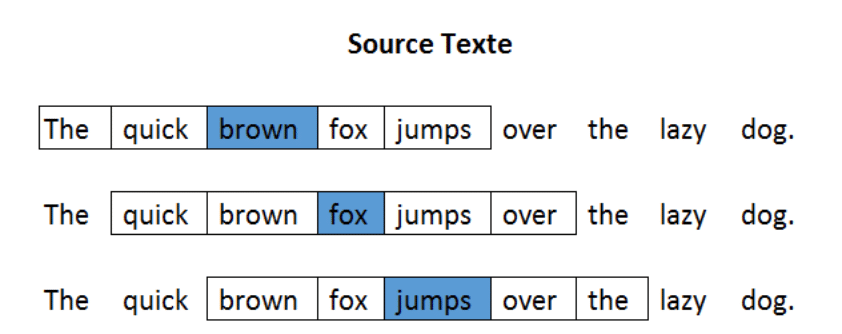


**CBOW :**

Le modèle est nourri par le contexte, et prédit le mot cible. Le résultat de la couche cachée est la nouvelle représentation du mot (ℎ1, …, ℎ𝑁).
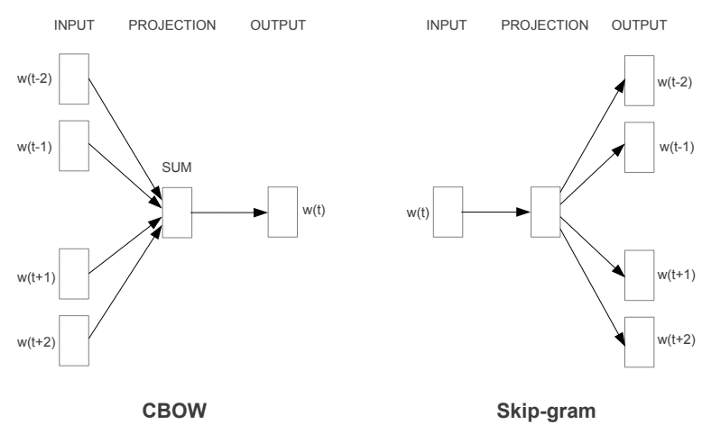

**Skip Gram :**

Le modèle est nourri par le mot cible, et prédit les mots du contexte. Le résultat de la couche cachée est la nouvelle représentation du mot (ℎ1, …, ℎ𝑁).

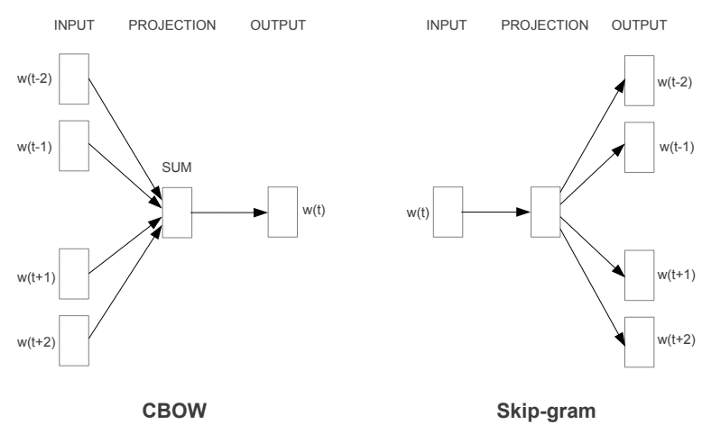


- La couche Embedding va transformer chaque mot du contexte en vecteur d’embedding. La matrice W de l’embedding sera apprise au fur et à mesure que le modèle s’entraîne. Les dimensions résultantes sont : (lot, context_size, embedding).
- Ensuite, la couche GlobalAveragePooling1D permet de sommer les différents embedding pour avoir une dimension en sortie (batch_size, embedding).
- Enfin, La couche Dense de taille « voc_size » permet de prédire le mot cible.

## a.Tweets lemmatized

### Split train and test

In [56]:
# Storing data in lists.

tweet_lemmatized , target = (df_sample['tweet_lemmatized']), (df_sample['target'])
# Let's split the whole dataset into a training set (70% of data) and a test set (30% of data)
# The dataset will be split in a stratified way, in order to have a good distribution of the target variable
X_train,X_test,y_train,y_test = train_test_split(tweet_lemmatized , target, test_size=0.3, random_state=1)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 11200
TEST size: 4800


### Tokenize/Padding datasets

**Le padding(remplissage):**
est le processus par lequel nous pouvons ajouter des jetons de remplissage au début ou à la fin d'une phrase pour augmenter sa longueur jusqu'à la taille requise. Si nécessaire, nous pouvons également supprimer certains mots pour les réduire à la longueur spécifiée.

In [57]:
#Tokenize Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 12688


In [5]:
vocab_size

NameError: name 'vocab_size' is not defined

In [58]:
max(sizes)

235

In [59]:
%%time
# Tokéniser les jeux de données X_train et X_test et les remplir à la longueur SEQUENCE_LENGTH

SEQUENCE_LENGTH = 235


X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)


Wall time: 285 ms


In [60]:
print("X_train", X_train.shape)
print("X_test", X_test.shape)

X_train (11200, 235)
X_test (4800, 235)


### Label Encoding

In [61]:
encoder = LabelEncoder()
encoder.fit(target.to_list())

y_train = encoder.transform(y_train.to_list())
y_test = encoder.transform(y_test.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (11200, 1)
y_test shape: (4800, 1)


## Word_emedding

- Le word embedding désigne un ensemble de méthode d’apprentissage visant à représenter les mots d’un texte par des vecteurs de nombres réels. 
- Le word embedding est capable en réduisant la dimensionde capturer le contexte, la similarité sémantique et syntaxique (genre, synonymes, …) d’un mot.
- La méthode d’embedding généralement utilisée pour réduire la dimension d’un vecteur consiste à utiliser le résultat que retourne une couche dense, c’est à dire de multiplier une matrice d’embedding W par la représentation « one hot » du mot :

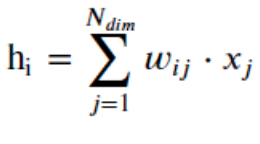  
Sous forme vectorielle :
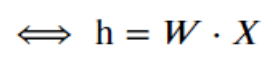
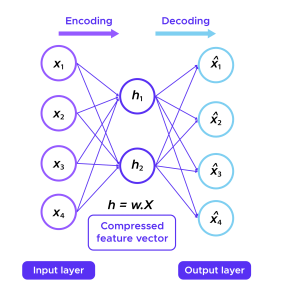

In [62]:
%%time
import zipfile
with zipfile.ZipFile('C:/Users/CE PC/Downloads/glove.6B.zip' , 'r') as zip_ref:
    zip_ref.extractall('C:/Users/CE PC/Documents/IA_P7/datas')

Wall time: 17.7 s


In [63]:
GLOVE_EMB = 'C:/Users/CE PC/Documents/IA_P7/datas/glove.6B.300d.txt '
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 20
MODEL_PATH = 'C:/Users/CE PC/Documents/IA_P7/datas'

In [64]:
%%time
embeddings_index = {}

f = open(GLOVE_EMB , encoding="utf8")
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.
Wall time: 55.4 s


- **Embedding Matrix** est une maxtrice de tous les mots et de leurs incorporations correspondantes. 
Nous utilisons une **Embedding Matrix** dans une couche **Embedding layer** de notre modèle pour intégrer un jeton dans sa représentation vectorielle, qui contient des informations concernant ce jeton ou ce mot.

- Nous obtenons le vocabulaire d'intégration du tokenizer et les vecteurs correspondants du modèle Embedding, qui dans ce cas est le modèle Word2Vec.

- La forme de **Embedding Matrix** est généralement la longueur du vocabulaire * la dimension d'intégration.

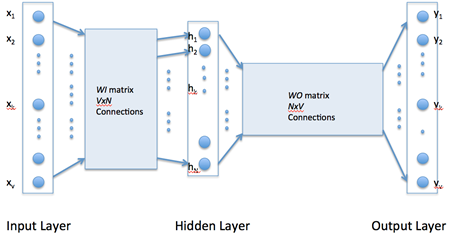


In [65]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    
if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [66]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=SEQUENCE_LENGTH,
                                          trainable=False)

##### Creating the Model

Nous allons construire un modèle de séquence d'apprentissage en profondeur.

Le modèle de séquence est très efficace pour saisir le contexte d'une phrase, car il peut comprendre le sens plutôt que d'employer des techniques telles que le comptage de mots positifs ou négatifs comme dans un modèle de **Bag-of-Words**.

**Architecture du modèle**

**1.Embedding Layer** : couche responsable de la conversion des jetons en leur représentation vectorielle générée par le modèle Word2Vec. Nous utilisons la couche prédéfinie de Tensorflow dans notre modèle.

**Arguments**

   - input_dim : Taille du vocabulaire.
   - output_dim : Dimension de l'encastrement dense.
   - weights : lance la matrice d'intégration.
   - traînable : spécifie si la couche peut être entraînée ou non.


**2. Bidirectionnel** : wrapper bidirectionnel pour les RNN. Cela signifie que le contexte est transporté de gauche à droite et de droite à gauche dans la couche RNN enveloppée.

**3. LSTM: Long Short Term Memory**: c'est une variante de RNN qui a une cellule d'état de mémoire pour apprendre le contexte des mots qui sont plus loin dans le texte pour porter une signification contextuelle plutôt que juste des mots voisins comme dans le cas de RNN.

**Arguments**

   - **units :** Entier positif, dimensionnalité de l'espace de sortie.
   - **dropout :** Fraction des unités à supprimer pour la transformation linéaire des entrées.
   - **return_sequence :** s'il faut renvoyer la dernière sortie de la séquence de sortie ou la séquence complète.
   
**4. Conv1D :** cette couche crée un noyau de convolution qui est convolué avec l'entrée de la couche sur une seule dimension pour produire un tenseur de sorties.

**Arguments**

   - **filtres :** la dimensionnalité de l'espace de sortie (c'est-à-dire le nombre de filtres de sortie dans la convolution)
   - **kernel_size :** spécifie la longueur de la fenêtre de convolution 1D.
   - **activation :** spécifie la fonction d'activation à utiliser.
   
   
**5. GlobalMaxPool1D :**  sous-échantillonne la représentation d'entrée en prenant la valeur maximale sur les différentes dimensions.

**6. Dense :** la couche dense ajoute une couche entièrement connectée dans le modèle. L'argument passé spécifie le nombre de nœuds dans cette couche.

**7. La dernière couche dense** a l'activation "Sigmoïde", qui est utilisée pour transformer l'entrée en un nombre compris entre 0 et 1. Les activations sigmoïdes sont généralement utilisées lorsque nous avons 2 catégories pour la sortie.

In [67]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [68]:
sequence_input = Input(shape=(SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

##### Training the Model

**Model Callbacks**

**Callbacks** sont des objets qui peuvent effectuer des actions à différentes étapes de la formation.
Nous pouvons utiliser des Callbacks pour écrire des **TensorBoard logs** après chaque lot de formation, enregistrer périodiquement notre modèle, arrêter la formation plus tôt ou même pour avoir une vue sur les états internes et les statistiques pendant la formation.

**ReduceLROnPlateau :** réduit le taux d'apprentissage chaque fois que le gain de la métrique de performance spécifiée cesse de s'améliorer.

- monitor : quantité à surveiller.
- patience : nombre d'époques sans amélioration après lesquelles le taux d'apprentissage sera réduit.
- cooldown : nombre d'époques à attendre avant de reprendre le fonctionnement normal après la réduction de lr.

**EarlyStopping :** arrête l'entraînement lorsqu'une métrique surveillée a cessé de s'améliorer.

- monitor : Quantité à surveiller.
- min_delta : changement minimum de la quantité surveillée pour être considéré comme une amélioration, c'est-à-dire un changement absolu inférieur à min_delta, comptera comme aucune amélioration.
- patience : Nombre d'époques sans amélioration après lesquelles l'entraînement sera arrêté.

##### Model Compile

In [69]:
model.compile(optimizer=Adam(learning_rate=LR), 
              loss='binary_crossentropy',
              metrics=['accuracy'])


ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)


#model_train.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [70]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


In [71]:
%%time
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/20
11/11 [==============================] - 164s 14s/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5077 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 196s 18s/step - loss: 0.6931 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5077 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 245s 23s/step - loss: 0.6932 - accuracy: 0.4883 - val_loss: 0.6931 - val_accuracy: 0.5077 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 257s 24s/step - loss: 0.6931 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.4923 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 229s 21s/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4923 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 248s 23s/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4923 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 252s 23s/step - lo

##### Model Evaluation

**Les courbes d'apprentissage** montrent la relation entre la taille de l'ensemble d'apprentissage et la métrique d'évaluation que nous avons choisie sur nos ensembles d'apprentissage et de validation. Ils peuvent être un outil extrêmement utile lors du diagnostic des performances de notre modèle, car ils peuvent nous dire si notre modèle souffre de biais ou de variance.

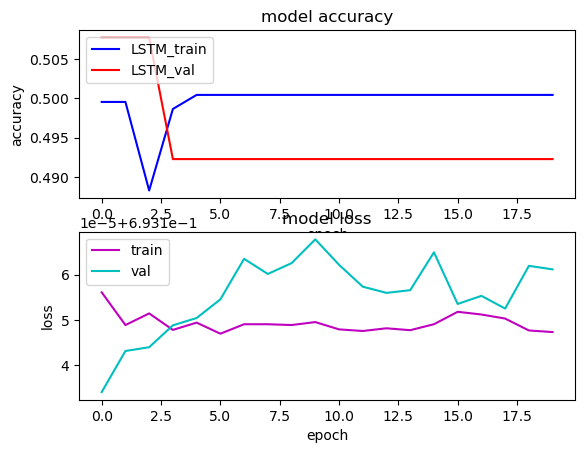

In [72]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')



al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

##### Confusion Matrix

In [73]:
lab_to_sentiment = {0:"Negative", 1:"Positive"}
def label_decoder(label):
    return lab_to_sentiment[label]
df_sample.target = df_sample.target.apply(lambda x: label_decoder(x))
df_sample.head()

,target,tweet,tweet_preprocessed,tweet_lemmatized,tweet_stem
425383,Negative,says I really love my phone!! But i need a ne...,says love phone need new URL,say love phone need new URL,say love phone need new url
227432,Negative,"Ohhh I love you and i miss you @heeymary , i ...",ohh love miss USER want x3,ohh love miss USER want x3,ohh love miss user want x3
1073041,Positive,@williepryorjr Hahaha.,USER hahaha,USER hahaha,user hahaha
872313,Positive,@jasongroupp 0% here in Oregon.,USER oregon,USER oregon,user oregon
337030,Negative,i'm going to kill my dog she just ate my flip ...,going kill dog ate flip flops buy new pair,going kill dog ate flip flop buy new pair,go kill dog ate flip flop buy new pair


In [74]:
train_data, test_data = train_test_split(df_sample, test_size=0.3, random_state=1)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 11200
Test Data size 4800


In [75]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(X_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 11s 11s/step


In [77]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    


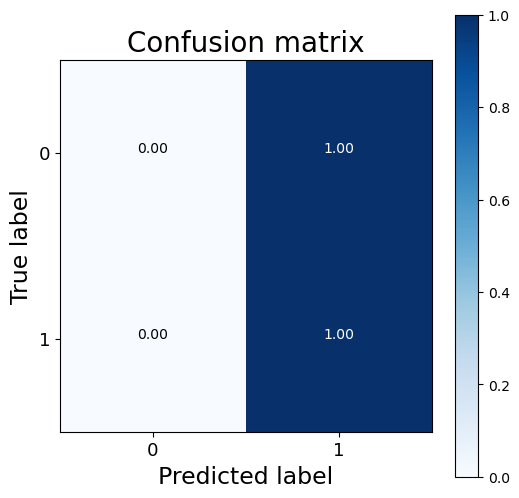

Wall time: 365 ms


In [82]:
%%time

cnf_matrix = confusion_matrix(y_test, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="Confusion matrix")
plt.show()

##### Classification Scores

In [4]:
print(classification_report(X_test, y_pred_1d))

NameError: name 'X_test' is not defined

In [81]:
cnf_matrix = confusion_matrix(test_data.target.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.target.unique(), title="Confusion matrix")
plt.show()

ValueError: Mix of label input types (string and number)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_train.unique(), title="Confusion matrix")
plt.show()

**Conclusion:**

- À partir de la courbe d'apprentissage, nous pouvons conclure que notre modèle n'a pas de biais ni de surajustement. 

- La courbe de précision s'est aplatie mais continue d'augmenter, ce qui signifie que l'entraînement sur plus d'époques peut donner de meilleurs résultats.

- La perte de validation est inférieure à la perte d'apprentissage car les abandons dans LSTM ne sont pas actifs lors de l'évaluation du modèle.

##### Predict

In [ ]:
def decode_sentiment(score):
    return 0 if score < 0.5 else 1

In [ ]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    X_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([X_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  


In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

#### Twwets Steeming

In [ ]:
# Storing data in lists.
tweet_stemming , target = (df_sample['tweet_stem']), (df_sample['target'])
# Let's split the whole dataset into a training set (70% of data) and a test set (30% of data)
# The dataset will be split in a stratified way, in order to have a good distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(tweet, target, test_size=0.3, random_state=1)


##### Initialise the model Word2Vec

In [ ]:
%%time

Word2vec_train_data = [_text.split() for _text in X_train] 

In [ ]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

w2v_model = gensim.models.word2vec.Word2Vec( vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(Word2vec_train_data)

In [ ]:
#words = w2v_model.wv.vocab.keys()
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

In [ ]:
%%time
w2v_model.train(Word2vec_train_data, total_examples=len(Word2vec_train_data), epochs=W2V_EPOCH)

In [ ]:
w2v_model.wv.most_similar("love")

##### Tokenize Text

In [ ]:
#Tokenize Text


tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_stemming)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

In [ ]:
%%time
# KERAS
SEQUENCE_LENGTH = 300

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

##### Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:

        embedding_matrix[i] = w2v_model.wv[word]

print(embedding_matrix.shape)

In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


##### Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()


##### Compile model

In [ ]:
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

##### Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss',patience=5, cooldown=0),
            EarlyStopping(monitor='val_acc',
                           min_delta=1e-4, patience=5)]


##### Train

In [ ]:
%%time

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
%%time
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

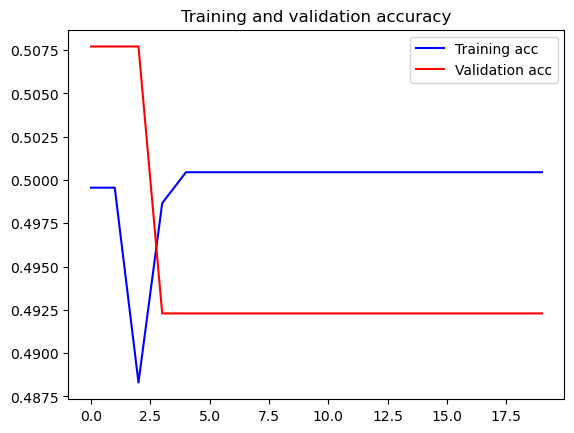

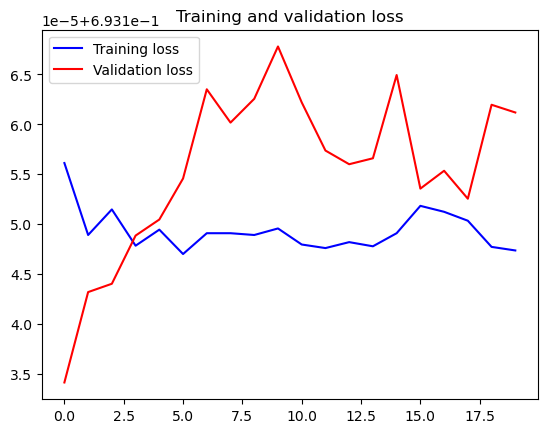

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

##### Predict

In [ ]:
def decode_sentiment(score):

    return 0 if score < 0.5 else 1

def predict(text):

    start_at = time.time()

    # Tokenize text

    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)

    # Predict

    score = model.predict([x_test])[0]

    # Decode sentiment

    label = decode_sentiment(score)



    return {"label": label, "score": float(score),"elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")


In [ ]:
predict("i don't know what i'm doing")


##### Confusion Matrix

In [84]:
%%time

y_pred_1d = []

y_test_1d = list(y_test)

scores = model.predict(X_test, verbose=1, batch_size=8000)

y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 9s 9s/step
Wall time: 8.73 s


In [85]:
def plot_confusion_matrix(cm, classes,

                          title='Confusion matrix',

                          cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title, fontsize=30)

    plt.colorbar()

    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)

    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, format(cm[i, j], fmt),

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=15)

    plt.xlabel('Predicted label', fontsize=15)


In [ ]:
np.unique(y_train)

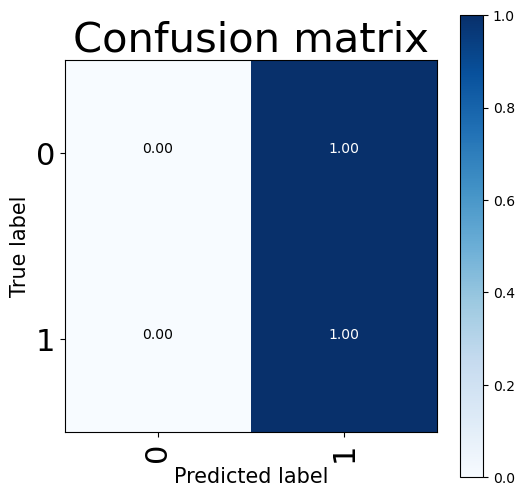

Wall time: 376 ms


In [86]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="Confusion matrix")
plt.show()

In [ ]:
### 2. GLOVE

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

## Initialise the model Word2Vec

**Paramètres Word2Vec():**

- **vector_size :** Le nombre de dimensions (N) sur lesquelles Word2Vec mappe les mots. Des valeurs de taille plus grandes nécessitent plus de données d'entraînement, mais peuvent conduire à de meilleurs modèles (plus précis).

- **workers:**  Spécifie le nombre de threads de travail pour la parallélisation de la formation, afin d'accélérer la formation.

- **min_count:** min_count sert à élaguer le dictionnaire interne. Les mots qui n'apparaissent qu'une ou deux fois dans un corpus d'un milliard de mots sont probablement des fautes de frappe et des ordures sans intérêt. De plus, il n'y a pas assez de données pour faire une formation significative sur ces mots, il est donc préférable de les ignorer.